In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from ssim_spearman_eval import ssim_corr_eval
from mae import IF_MAE
from sklearn.manifold import TSNE
from skimage.io import imread
from data import SingleCellDataset
from torch.utils.data import DataLoader

In [3]:
ls /var/local/ChangLab/panel_reduction/

CRC-ORION/           CRC-TMA-2-cell-masks/  TMA4-CellTiles-2/
CRC-ORION-adjusted/  CRC-WSI/               TMA4-CellTiles-2-cell-masks/
CRC-TMA/             CRC-WSI-cell-masks/
CRC-TMA-2/           TMA4-CellTiles/


In [4]:
#data_dir= '/var/local/ChangLab/panel_reduction/CRC-TMA'
#data_dir= '/var/local/ChangLab/panel_reduction/CRC-WSI'
data_dir= '/var/local/ChangLab/panel_reduction/TMA4-CellTiles'

files = [f'{data_dir}/{f}' for f in os.listdir(data_dir)][:1000]
val_data = SingleCellDataset(files)

val_loader = DataLoader(val_data, batch_size=1000, num_workers=0)

In [5]:
ch2stain = {0:"DAPI", 1:"CD3", 2:"ERK-1", 3:"hRAD51", 4:"CyclinD1", 5:"VIM", 6:"aSMA", 7:"ECad", 8:"ER", 9:"PR",
            10:"EGFR", 11:"Rb", 12:"HER2", 13:"Ki67", 14:"CD45", 15:"p21", 16:"CK14", 17:"CK19", 18:"CK17",
            19:"LaminABC", 20:"AR", 21:"Histone H2AX", 22:"PCNA", 23:"PanCK", 24:"CD31"}

In [6]:
ch2stain = {0:"DAPI", 1:"CD3", 2:"NaKATPase", 3:"CD45RO", 4:"Ki67", 5:"panCK", 6:"aSMA", 7:"CD4", 8:"CD45",
            9:"PD-1", 10:"CD20", 11:"CD68", 12:"CD8a", 13:"CD163", 14:"FOXP3", 15:"PD-L1", 16:"ECad", 17:"Vim",
            18:"CDX2", 19:"LaminABC", 20:"Desmin", 21:"CD31", 22:"PCNA", 23:"Ki67", 24:"Collagen IV"}

In [7]:
panel_channel_order = [0,7,16,12,14,9,18,22,24,1,11,6,2,15,23,13,21,5,3,4,20,8,19,17]
ckpt = 'ckpts/50p_mask_12l_dec.ckpt' #BC

In [8]:
ckpt = 'ckpts/crc_tma_25_mrkr.ckpt'
panel_channel_order = [0,9,8,4,20,13,1,12,6,11,14,24,17,3,15,21,10,19,16,7,5,18,22,2]

In [9]:
model = IF_MAE().load_from_checkpoint(ckpt)

In [10]:
panel = panel_channel_order[:9]
masked_ch_idx = torch.tensor([i for i in range(25) if i not in panel])
model.mae.masking_ratio = (25-9)/25
with torch.no_grad():
    targets,preds = model.forward(next(iter(val_loader))[0], masked_patch_idx=masked_ch_idx)

In [11]:
ims = next(iter(val_loader))[0]
preds = rearrange(preds, 'b c (h w) -> b h w c', h=32)
targets = rearrange(targets, 'b c (h w) -> b h w c', h=32)
orig = rearrange(torch.concat([v[0] for v in val_data][:10]), 'b (c1 h) (c2 w) -> b (c1 c2) h w',h=32, w=32)
preds[preds < 0] = 0

In [12]:
def view_rgb_image(sample_i, ch1_i, ch2_i, ch3_i):
    ch1 = preds[sample_i,:,:, ch1_i].unsqueeze(2)
    ch1_o = targets[sample_i,:,:,ch1_i].unsqueeze(2)
    ch2 = preds[sample_i,:,:, ch2_i].unsqueeze(2)
    ch2_o = targets[sample_i,:,:,ch2_i].unsqueeze(2)
    ch3 = preds[sample_i,:,:, ch3_i].unsqueeze(2)
    ch3_o = targets[sample_i,:,:,ch3_i].unsqueeze(2)
    ch1_i = ch1_i
    ch2_i = ch2_i
    ch3_i = ch3_i

    fig, ax = plt.subplots(1,8, figsize=(32,32))
    
    blank = np.zeros(ch1.shape)
    ax[0].imshow(np.concatenate([ch1, blank, blank], axis=2).astype('uint8'))
    ax[1].imshow(np.concatenate([ch1_o, blank, blank], axis=2).astype('uint8'))
    ax[2].imshow(np.concatenate([blank, ch2, blank], axis=2).astype('uint8'))
    ax[3].imshow(np.concatenate([blank, ch2_o, blank], axis=2).astype('uint8'))
    ax[4].imshow(np.concatenate([blank, blank, ch3], axis=2).astype('uint8'))
    ax[5].imshow(np.concatenate([blank, blank, ch3_o], axis=2).astype('uint8'))
    ax[6].imshow(np.concatenate([ch1, ch2, ch3], axis=2).astype('uint8'))
    ax[7].imshow(np.concatenate([ch1_o, ch2_o, ch3_o], axis=2).astype('uint8'))
    ax[0].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch1_i].item()]}', c='r', fontsize=24)
    ax[1].set_title(f'Real\n {ch2stain[masked_ch_idx[ch1_i].item()]}', c='r', fontsize=24)
    ax[2].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch2_i].item()]}', c='g', fontsize=24)
    ax[3].set_title(f'Real\n {ch2stain[masked_ch_idx[ch2_i].item()]}', c='g', fontsize=24)
    ax[4].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch3_i].item()]}', c='b', fontsize=24)
    ax[5].set_title(f'Real\n {ch2stain[masked_ch_idx[ch3_i].item()]}', c='b', fontsize=24)
    ax[6].set_title('Reconstructed\n Composite', fontsize=24)
    ax[7].set_title('Real\n Composite', fontsize=24)
    for a in fig.axes:
        a.axis('off')
    plt.savefig(f'plots/recon_panel_{ch1_i}.png',bbox_inches='tight')
    plt.show()

In [13]:
def view_rgb_image(sample_i, ch1_i, ch2_i, ch3_i):
    ch1 = preds[sample_i,:,:, ch1_i].unsqueeze(2)
    ch1_o = targets[sample_i,:,:,ch1_i].unsqueeze(2)
    ch2 = preds[sample_i,:,:, ch2_i].unsqueeze(2)
    ch2_o = targets[sample_i,:,:,ch2_i].unsqueeze(2)
    ch3 = preds[sample_i,:,:, ch3_i].unsqueeze(2)
    ch3_o = targets[sample_i,:,:,ch3_i].unsqueeze(2)
    ch1_i = ch1_i
    ch2_i = ch2_i
    ch3_i = ch3_i

    fig, ax = plt.subplots(1,8, figsize=(32,32))
    
    blank = np.zeros(ch1.shape)
    ax[0].imshow()
    ax[1].imshow(np.concatenate([ch1_o, blank, blank], axis=2).astype('uint8'))
    ax[2].imshow(np.concatenate([blank, ch2, blank], axis=2).astype('uint8'))
    ax[3].imshow(np.concatenate([blank, ch2_o, blank], axis=2).astype('uint8'))
    ax[4].imshow(np.concatenate([blank, blank, ch3], axis=2).astype('uint8'))
    ax[5].imshow(np.concatenate([blank, blank, ch3_o], axis=2).astype('uint8'))
    ax[6].imshow(np.concatenate([ch1, ch2, ch3], axis=2).astype('uint8'))
    ax[7].imshow(np.concatenate([ch1_o, ch2_o, ch3_o], axis=2).astype('uint8'))
    ax[0].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch1_i].item()]}', c='r', fontsize=24)
    ax[1].set_title(f'Real\n {ch2stain[masked_ch_idx[ch1_i].item()]}', c='r', fontsize=24)
    ax[2].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch2_i].item()]}', c='g', fontsize=24)
    ax[3].set_title(f'Real\n {ch2stain[masked_ch_idx[ch2_i].item()]}', c='g', fontsize=24)
    ax[4].set_title(f'Reconstructed\n {ch2stain[masked_ch_idx[ch3_i].item()]}', c='b', fontsize=24)
    ax[5].set_title(f'Real\n {ch2stain[masked_ch_idx[ch3_i].item()]}', c='b', fontsize=24)
    ax[6].set_title('Reconstructed\n Composite', fontsize=24)
    ax[7].set_title('Real\n Composite', fontsize=24)
    for a in fig.axes:
        a.axis('off')
    plt.savefig(f'plots/recon_panel_{ch1_i}.png',bbox_inches='tight')
    plt.show()

In [14]:
from itertools import combinations, permutations
from random import shuffle

In [15]:
panel

[0, 9, 8, 4, 20, 13, 1, 12, 6]

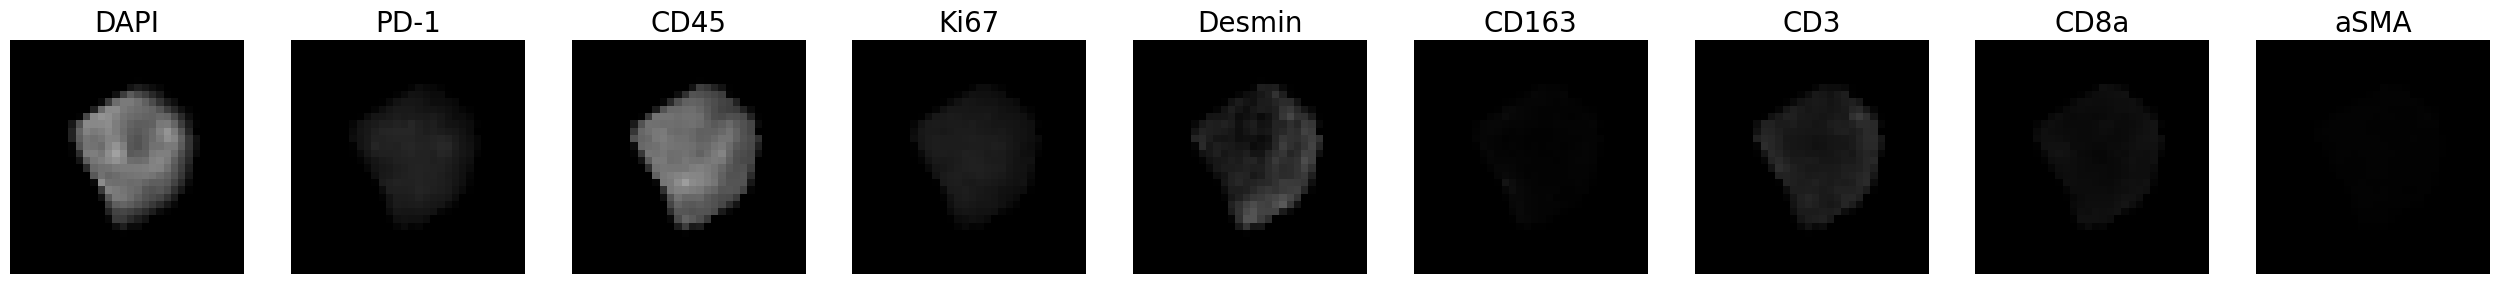

In [16]:
fig, ax = plt.subplots(1, len(panel), figsize=(32,32))
for a,i in zip(fig.axes, panel):
    a.set_title(f'{ch2stain[i]}', fontsize=20)
    ch = orig[7,i,:,:].unsqueeze(2).numpy().astype('uint8')
    a.imshow(np.concatenate([ch, ch, ch], axis=2))
    a.axis('off')
plt.savefig('plots/panel_ex.svg',bbox_inches='tight')

In [22]:
orig.shape

torch.Size([10, 25, 32, 32])

In [23]:
preds.shape

torch.Size([1000, 32, 32, 16])

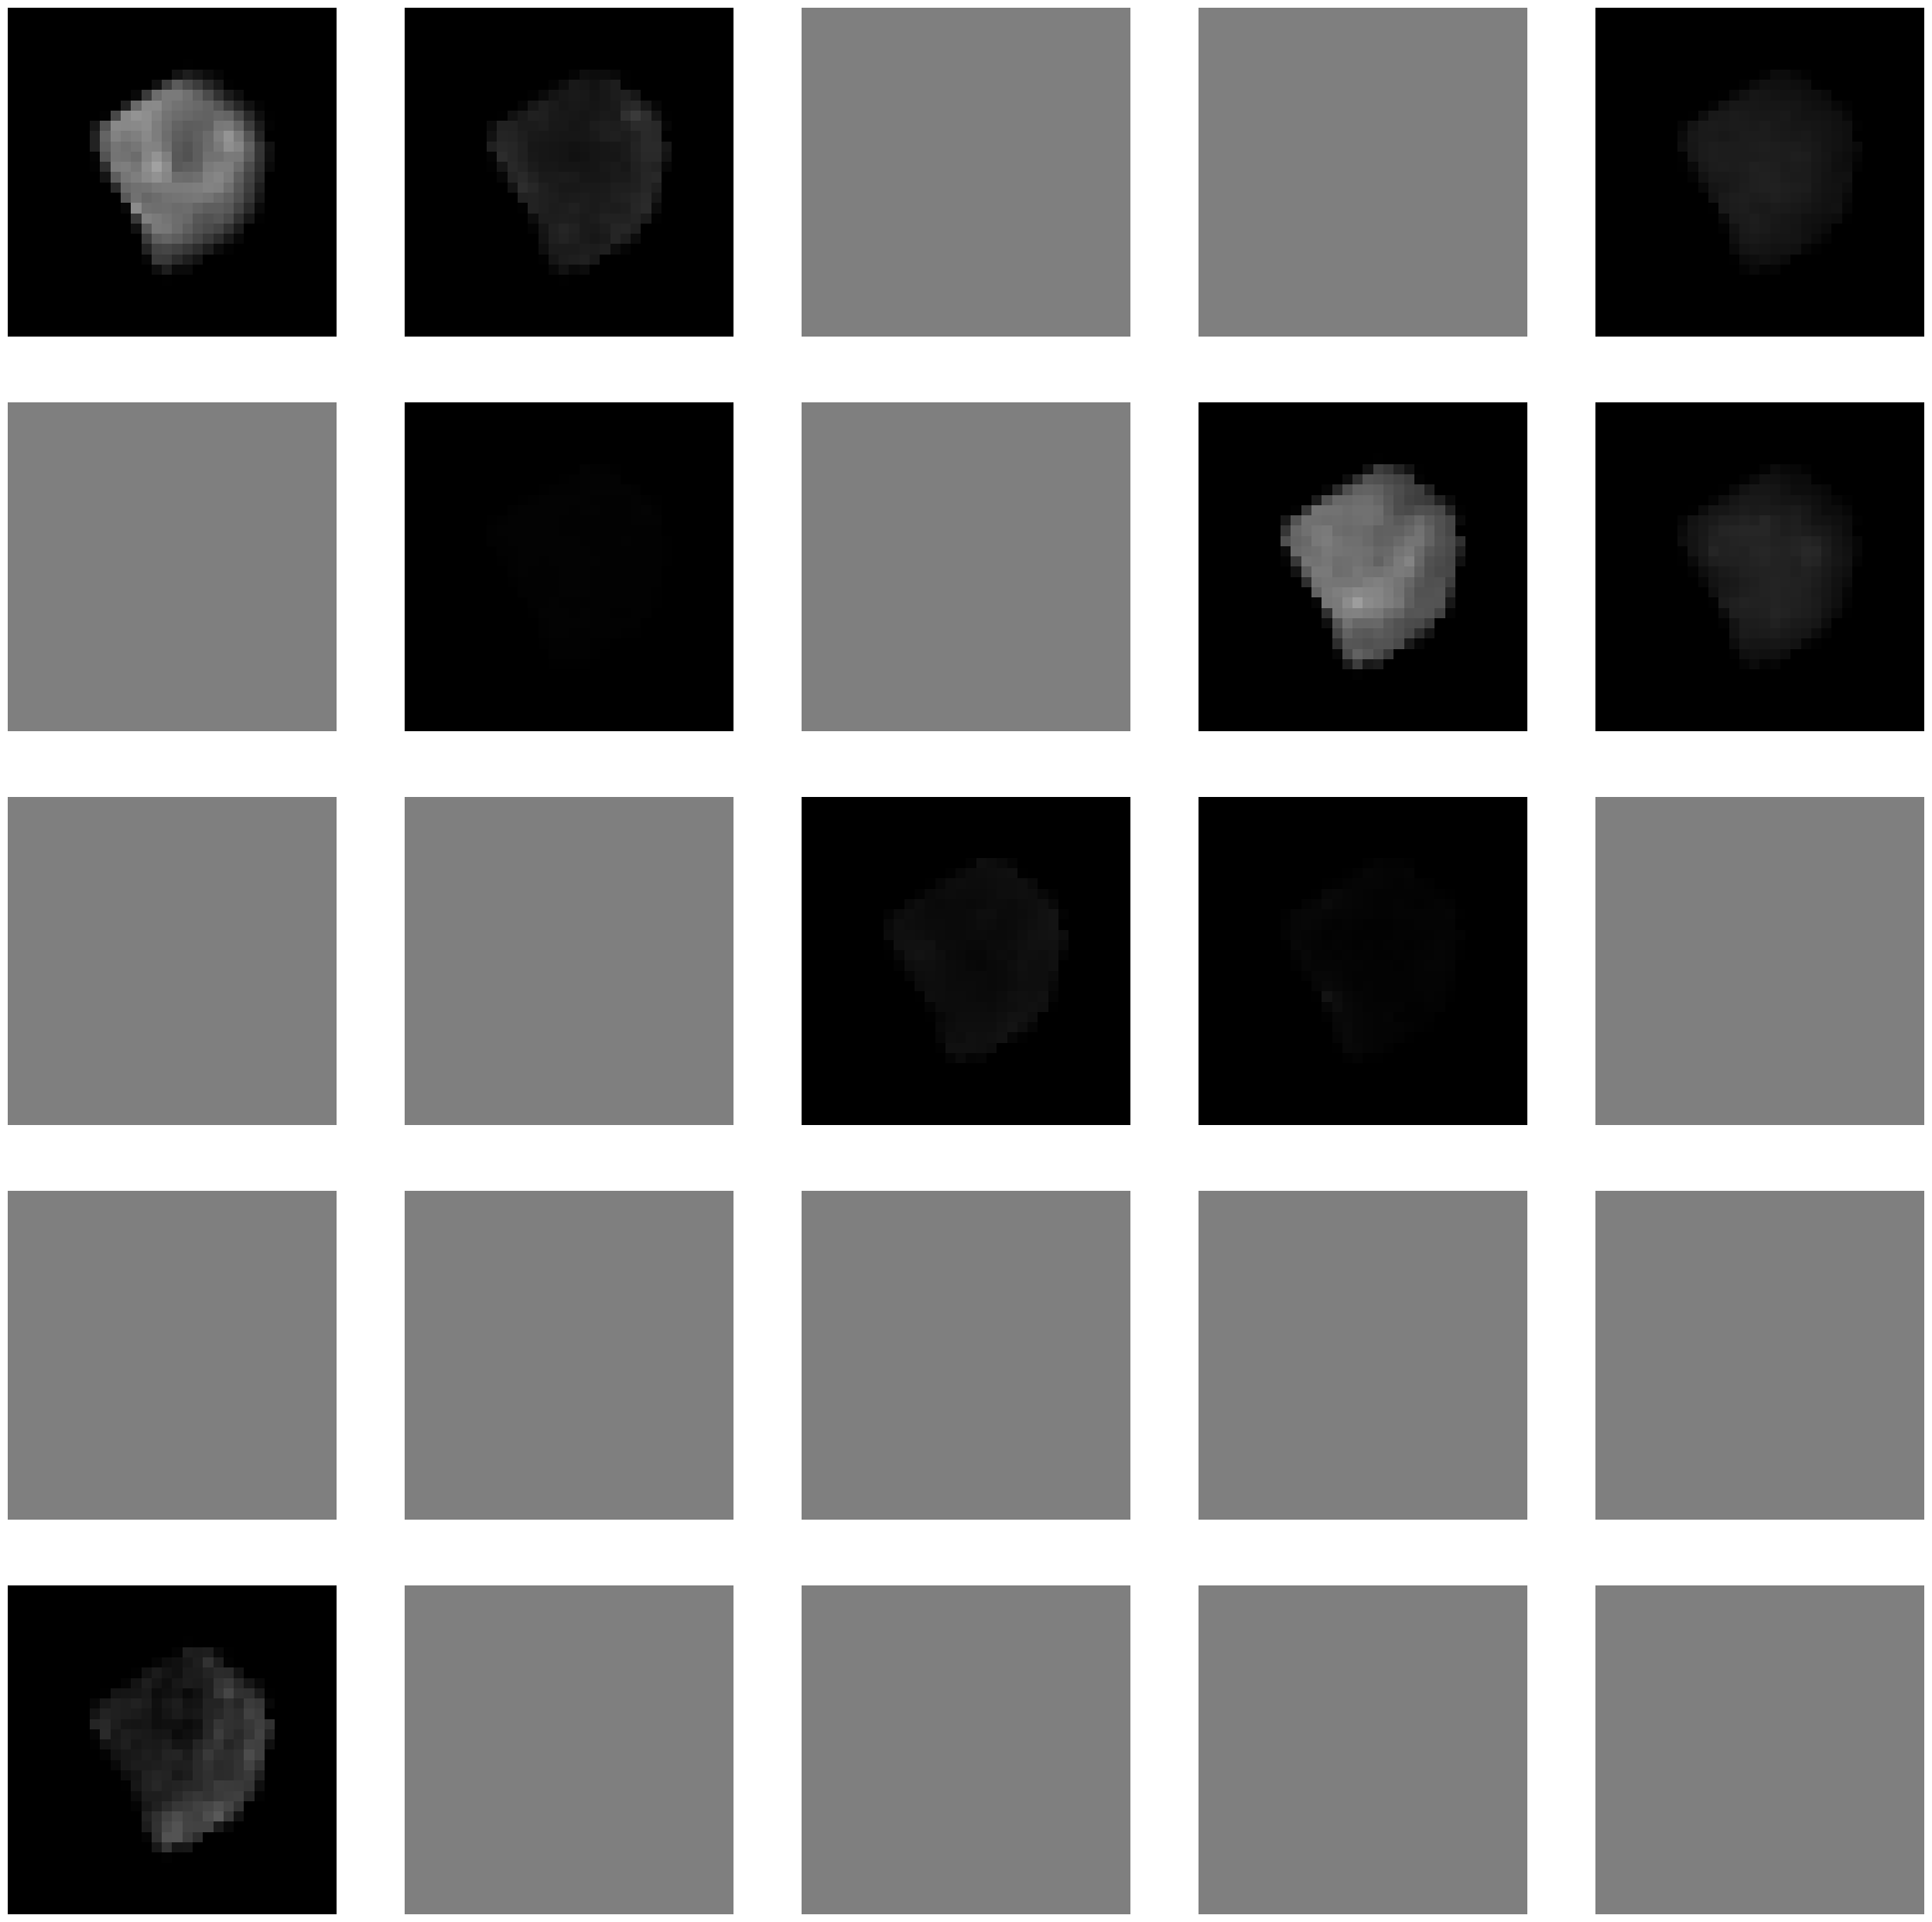

In [26]:
fig, ax = plt.subplots(5,5, figsize=(32,32))
for i,a in enumerate(fig.axes):
    if i in panel:
        ch = orig[7,i,:,:].unsqueeze(2).numpy().astype('uint8')
    else:
        ch = np.ones(ch.shape) * 0.5
    a.imshow(np.concatenate([ch, ch, ch], axis=2))
    a.axis('off')
plt.savefig('plots/panel_ex.svg',bbox_inches='tight')

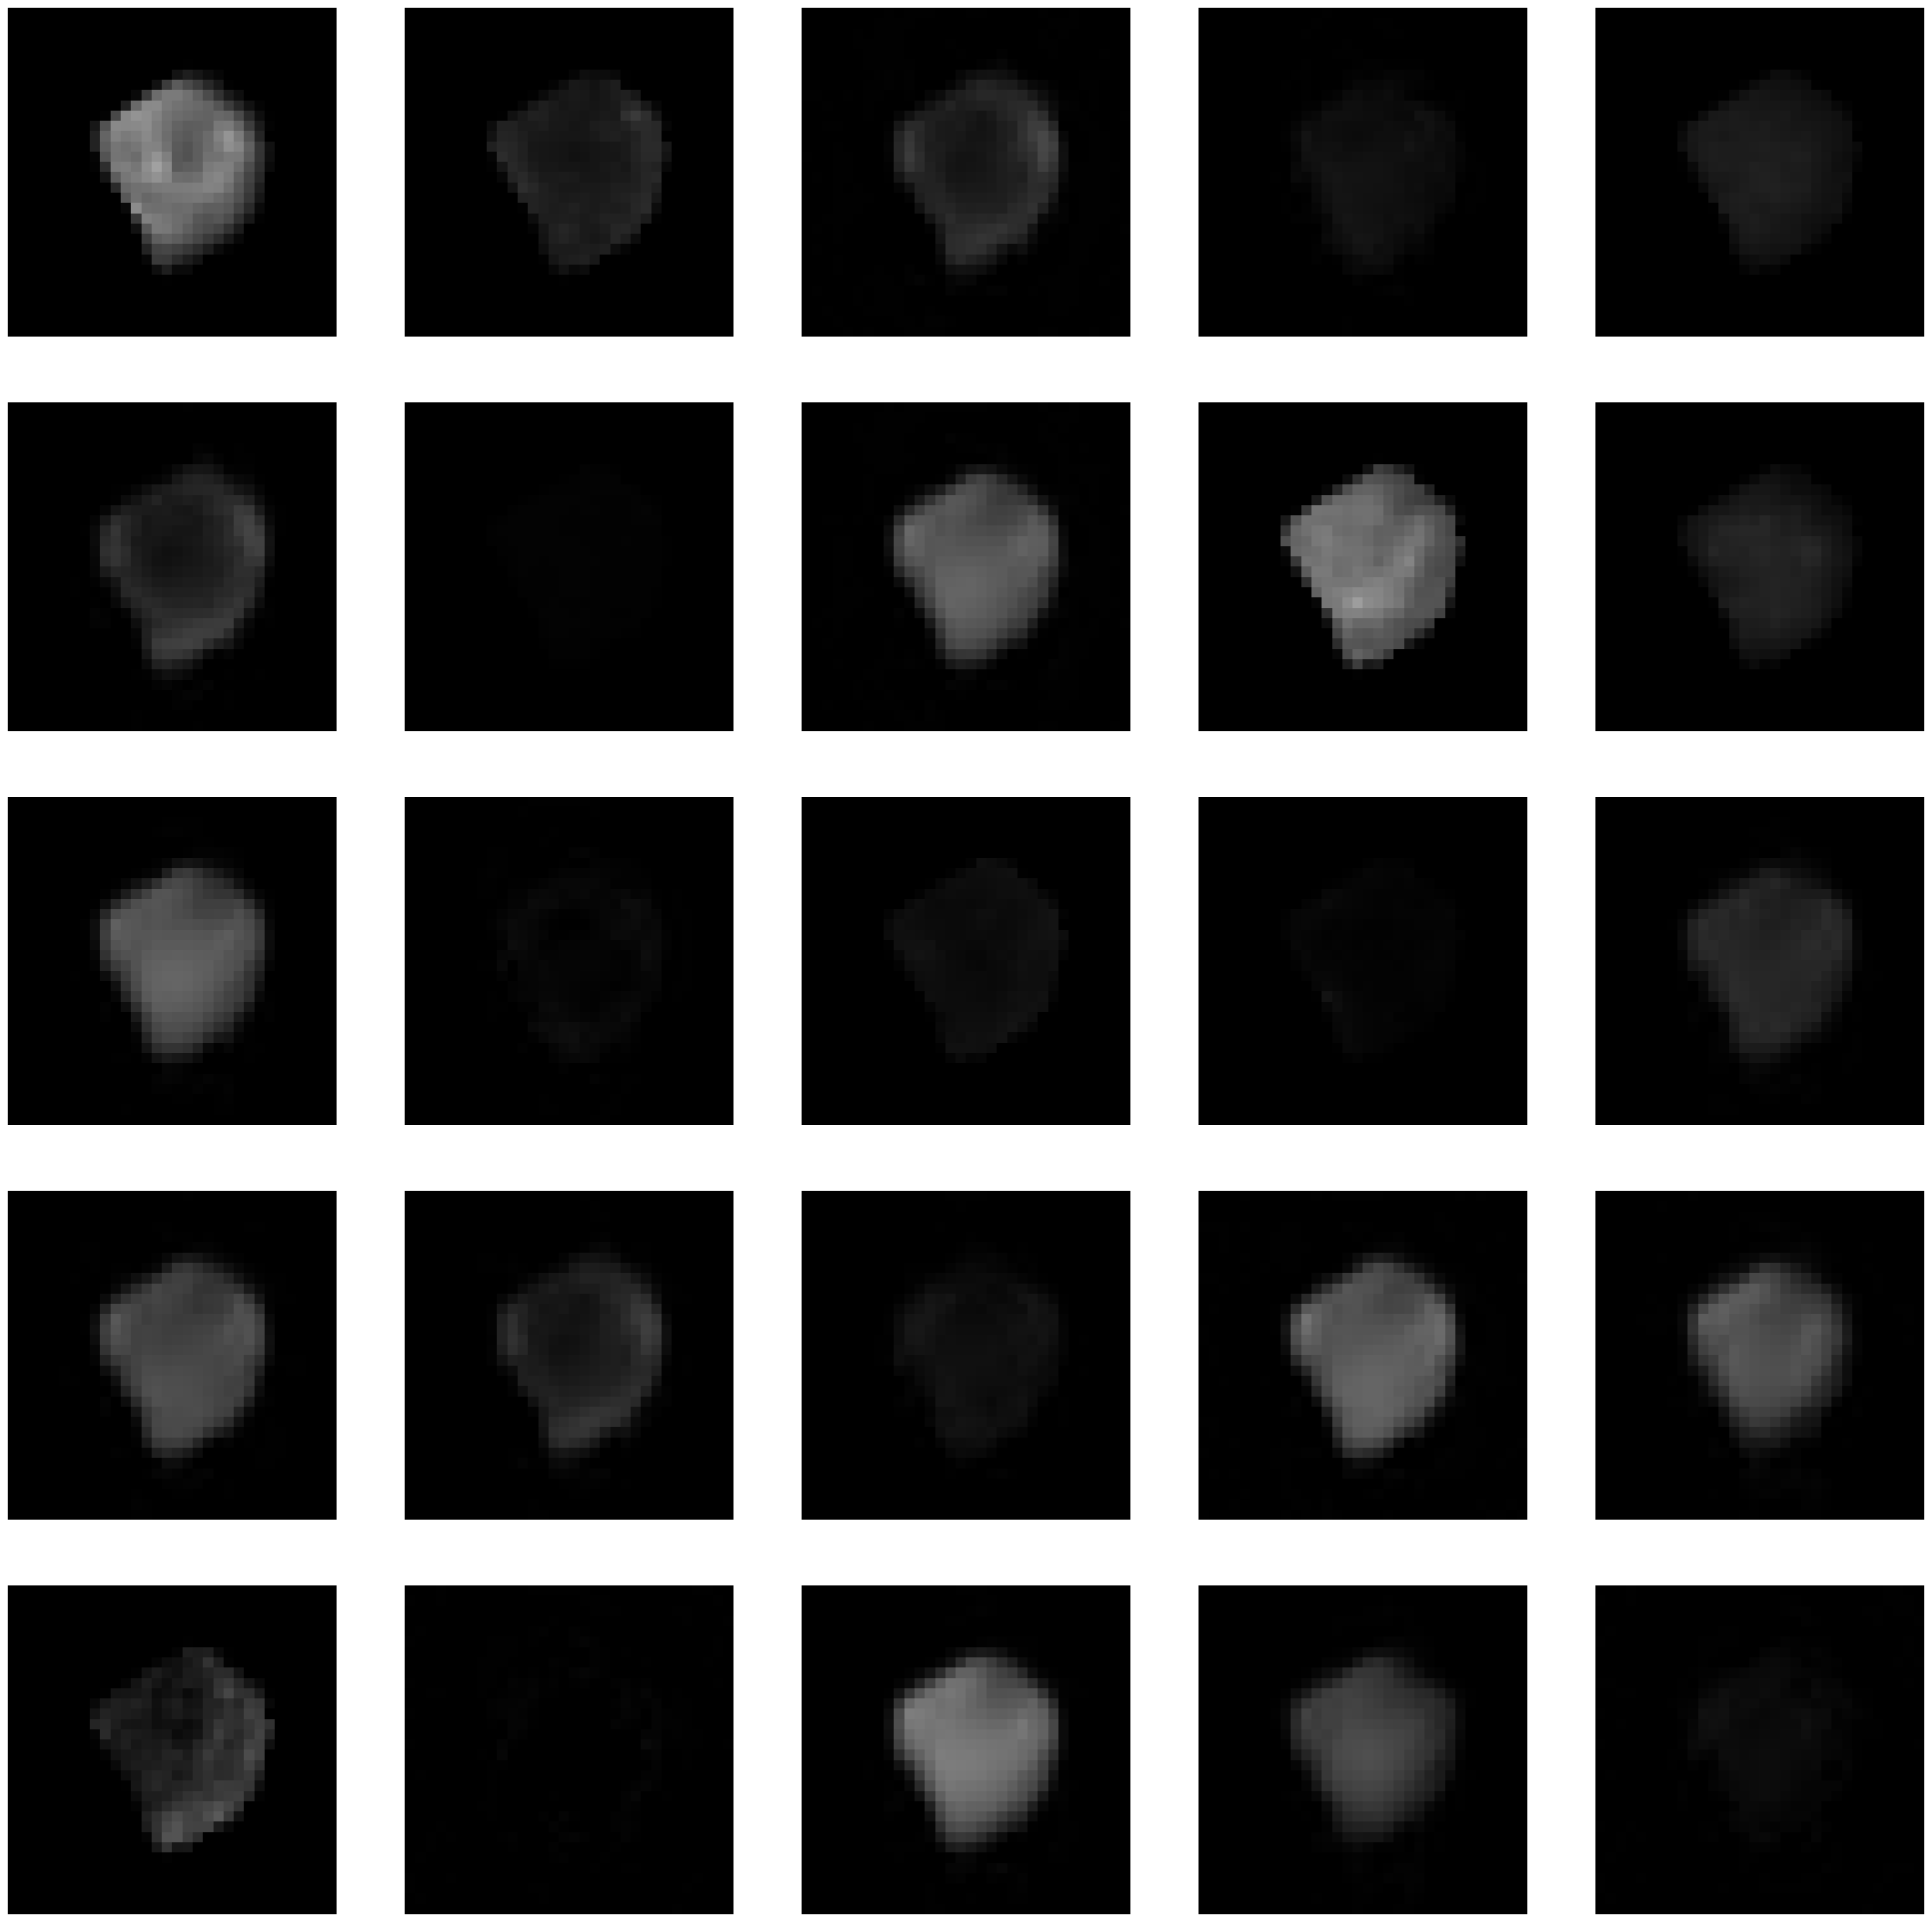

In [25]:
fig, ax = plt.subplots(5,5, figsize=(32,32))
j = 0
for i,a in enumerate(fig.axes):
    if i in panel:
        ch = orig[7,i,:,:].unsqueeze(2).numpy().astype('uint8')
    else:
        ch = preds[7,:,:,j].unsqueeze(2).numpy().astype('uint8')
        j += 1
    a.imshow(np.concatenate([ch, ch, ch], axis=2))
    a.axis('off')
plt.savefig('plots/panel_ex.svg',bbox_inches='tight')

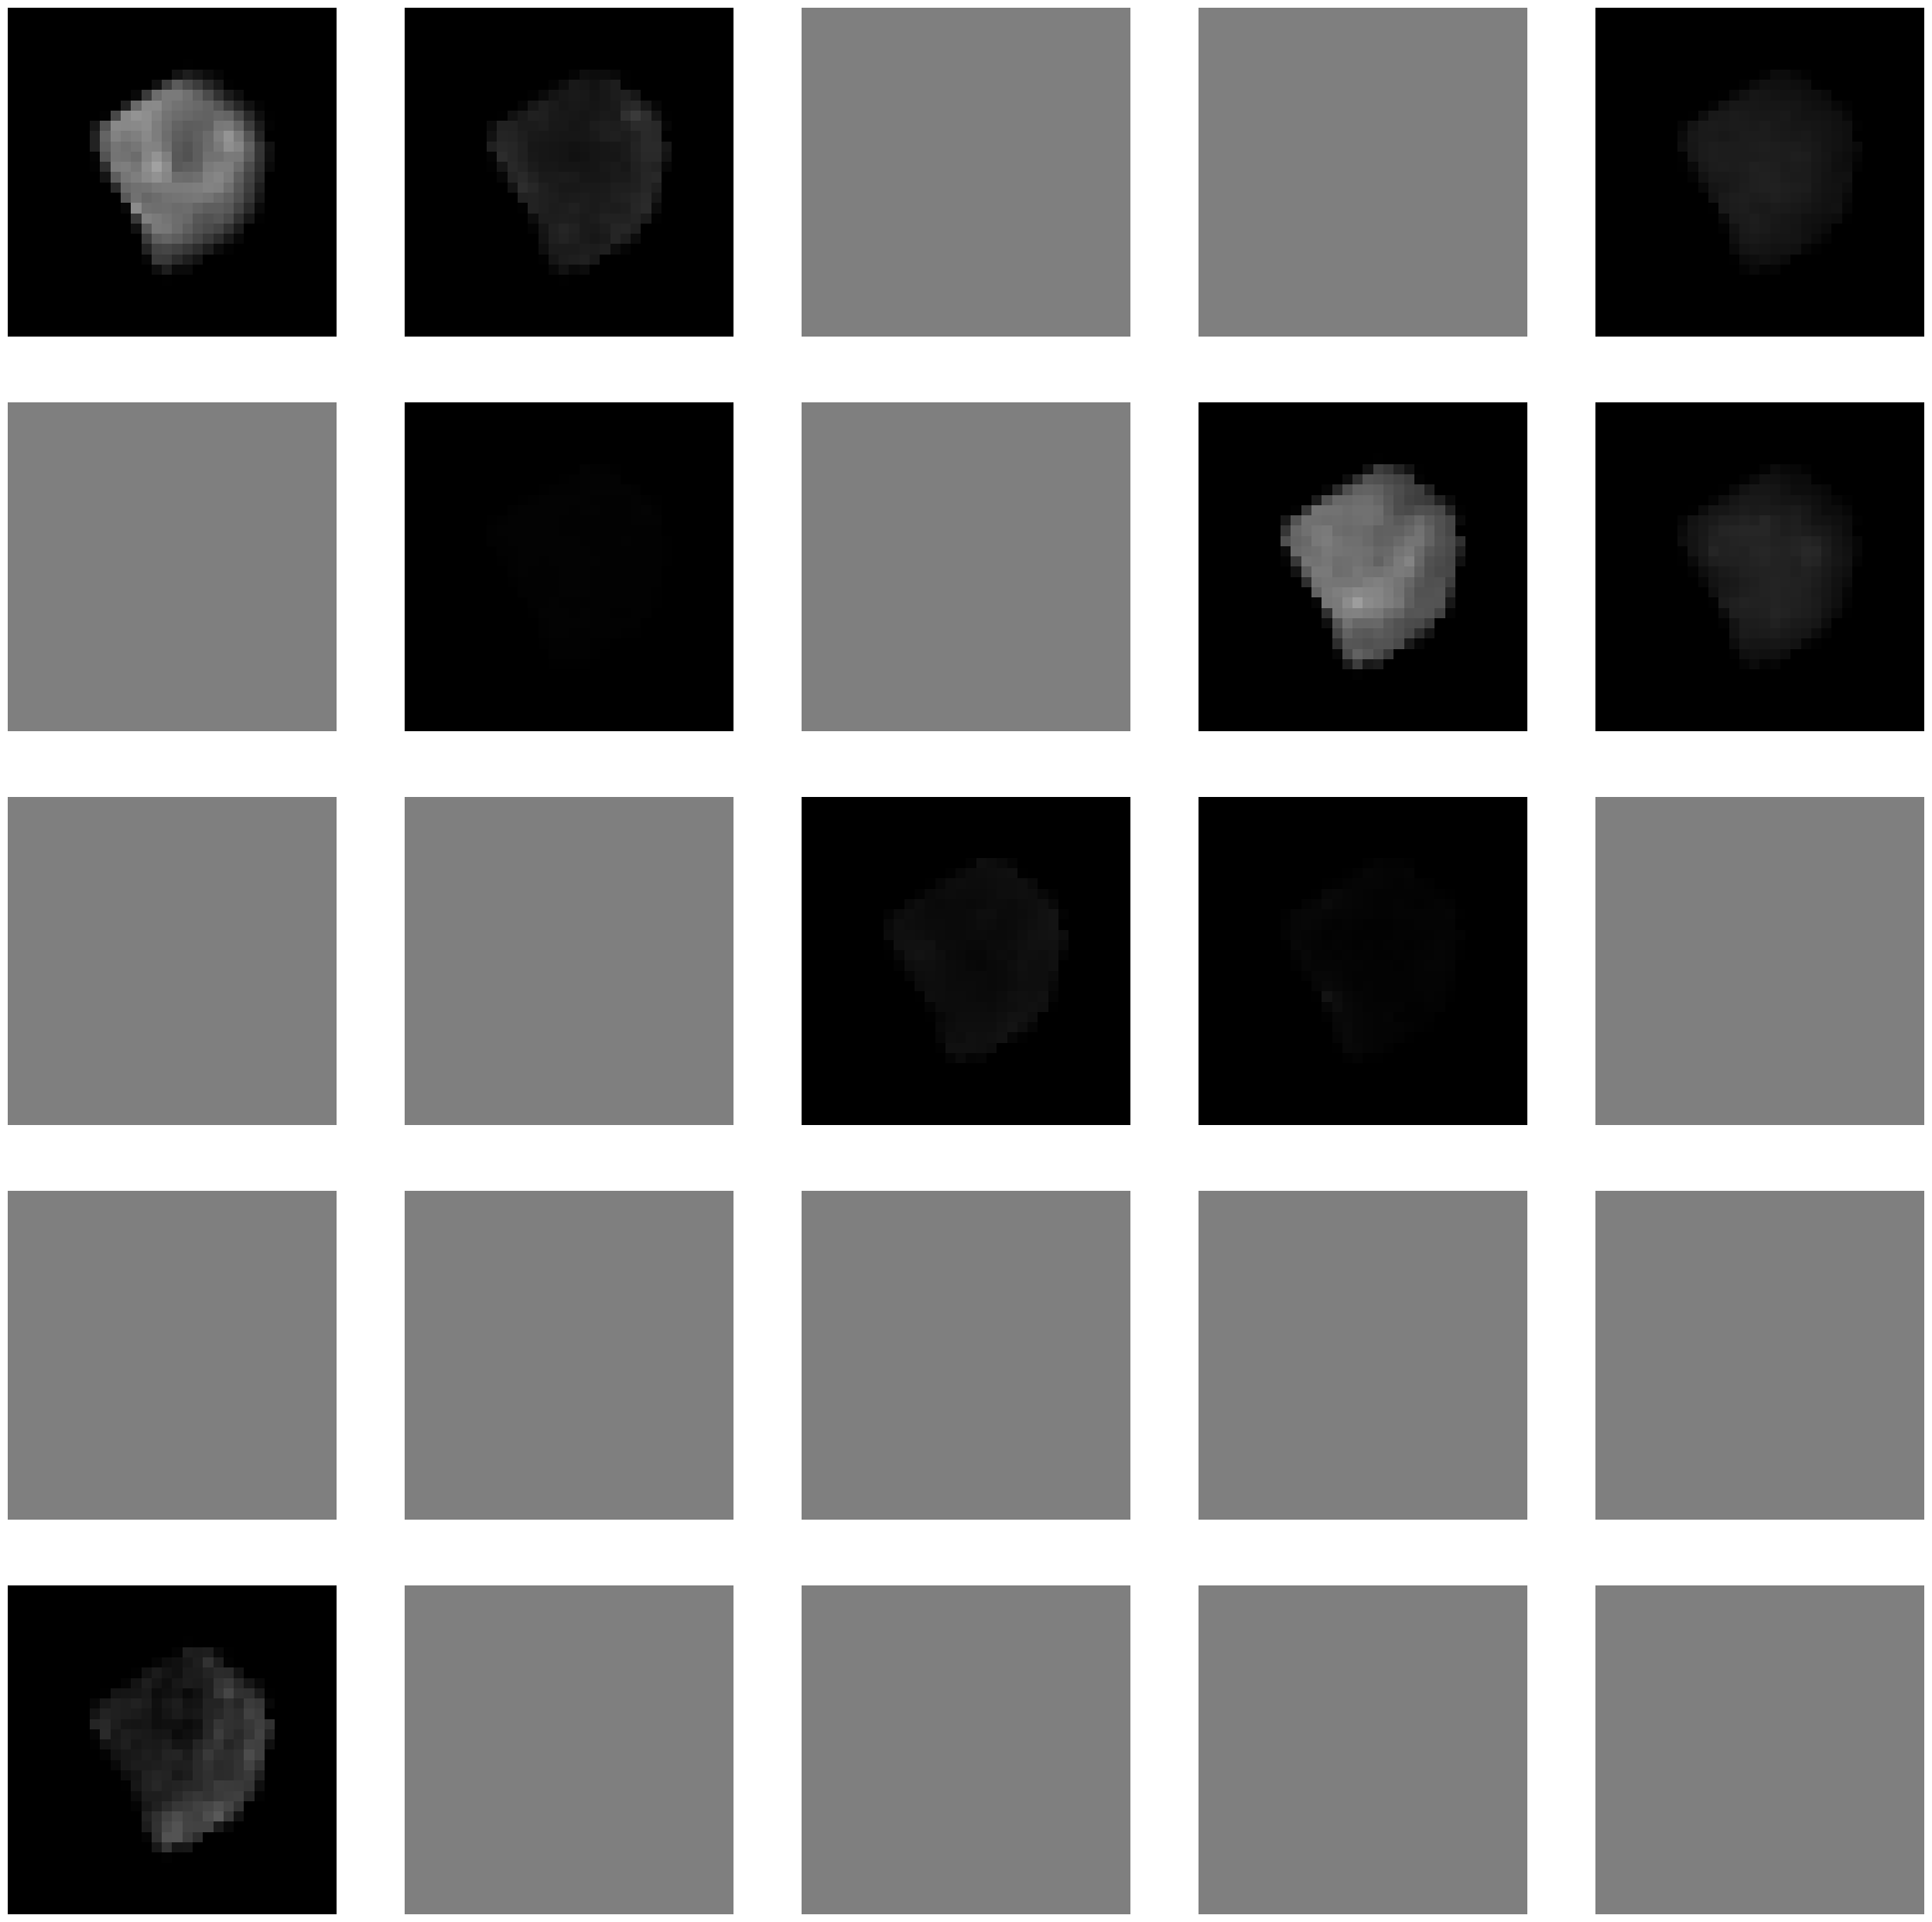

In [21]:
fig, ax = plt.subplots(5,5, figsize=(32,32))
for i,a in enumerate(fig.axes):
    if i in panel:
        ch = orig[7,i,:,:].unsqueeze(2).numpy().astype('uint8')
    else:
        ch = np.ones(ch.shape) * 0.5
    a.imshow(np.concatenate([ch, ch, ch], axis=2))
    a.axis('off')
plt.savefig('plots/panel_ex.svg',bbox_inches='tight')

In [16]:
l = [4, 0, 3, 12, 1, 15, 11, 9, 2, 6, 14, 7, 8, 13, 10, 5]

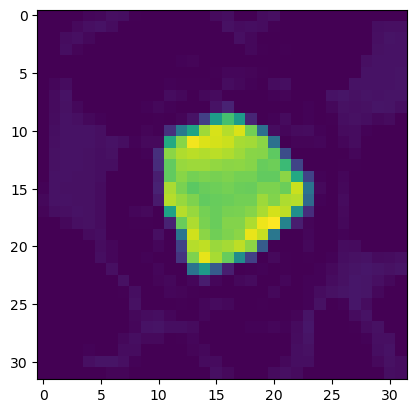

In [46]:
plt.imshow(preds[4,:,:,0])

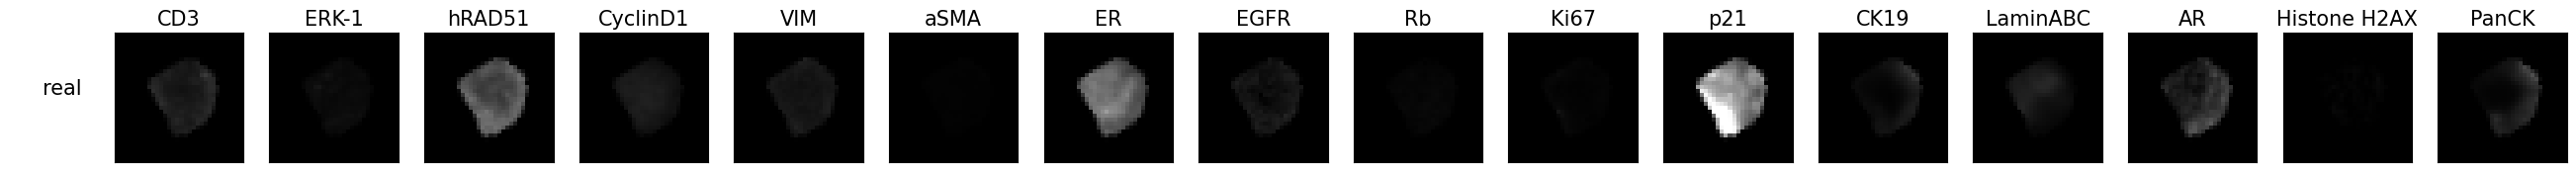

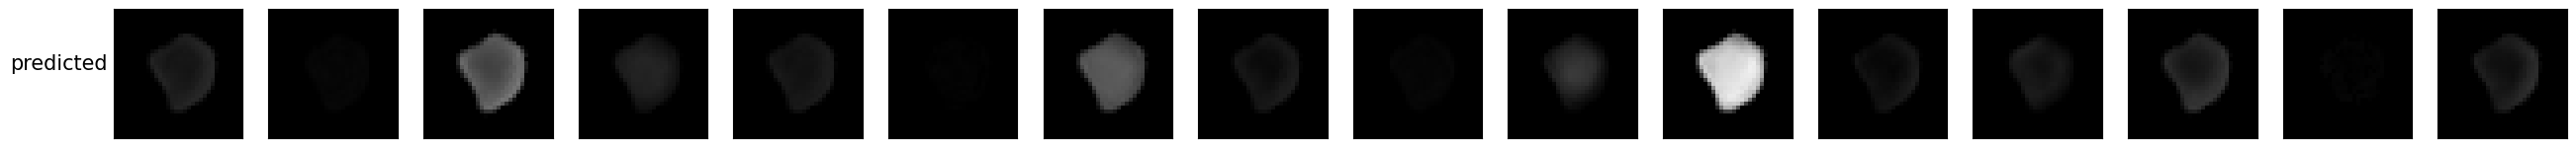

In [128]:
sample_i = 7
channels = [i for i in range(25) if i not in panel]
fig, ax = plt.subplots(1, 25 - len(panel), figsize=(32,32))
for i,c in enumerate(channels):
    target = targets[sample_i,:,:, i].unsqueeze(2).numpy().astype('uint8')
    ax[i].imshow(np.concatenate([target,target, target], axis=2))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('     real', rotation=0, fontsize=15, labelpad=50)
    ax[i].set_title(ch2stain[c], fontsize=15)
plt.show()
fig, ax = plt.subplots(1, 25 - len(panel), figsize=(32,32))
for i,c in enumerate(channels):
    pred = preds[sample_i,:,:, i].unsqueeze(2).numpy().astype('uint8')
    target = targets[sample_i,:,:,i]
    pred[target == 0] = 0
    ax[i].imshow(np.concatenate([pred,pred,pred], axis=2))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('predicted', rotation=0, fontsize=15, labelpad=40)
plt.show()

In [193]:
channels = [i for i in range(25) if i not in panel]
print({i:ch2stain[c] for i,c in enumerate(channels)})

{0: 'CD3', 1: 'ERK-1', 2: 'hRAD51', 3: 'CyclinD1', 4: 'VIM', 5: 'aSMA', 6: 'ER', 7: 'EGFR', 8: 'Rb', 9: 'Ki67', 10: 'p21', 11: 'CK19', 12: 'LaminABC', 13: 'AR', 14: 'Histone H2AX', 15: 'PanCK'}


In [218]:
def show_composite(ch_idxs, sample_i):
    ch2stain_ = {i:ch2stain[c] for i,c in enumerate(channels)}
    fig, ax = plt.subplots(1,2)
    pred1 = preds[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
    pred2 = preds[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
    pred3 = preds[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
    ax[0].text(21, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
    ax[0].text(21, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
    ax[0].text(21, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
    ax[0].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
    ax[0].axis('off')
    ax[0].set_title('Predicted Composite')

    pred1 = targets[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
    pred2 = targets[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
    pred3 = targets[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
    ax[1].text(21, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
    ax[1].text(21, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
    ax[1].text(21, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
    ax[1].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
    ax[1].axis('off')
    ax[1].set_title('Real Composite')

    plt.show()

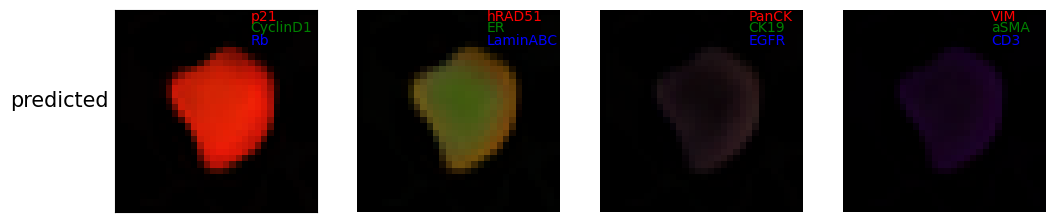

In [234]:
fig, ax = plt.subplots(1,4, figsize=(12,12))
sample_i = 7
ch2stain_ = {i:ch2stain[c] for i,c in enumerate(channels)}

#p21, CyclinD1, RB
ch_idxs = [10,3,8]
pred1 = preds[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
pred2 = preds[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
pred3 = preds[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
ax[0].text(21, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
ax[0].text(21, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
ax[0].text(21, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
ax[0].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel('predicted', rotation=0, fontsize=15, labelpad=40)

#HRad51 Histone H2AX laminABC
ch_idxs = [2,6,12]
pred1 = preds[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
pred2 = preds[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
pred3 = preds[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
ax[1].text(20, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
ax[1].text(20, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
ax[1].text(20, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
ax[1].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
ax[1].axis('off')

#Panck ck19 egfr
ch_idxs = 15, 11, 7
pred1 = preds[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
pred2 = preds[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
pred3 = preds[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
ax[2].text(23, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
ax[2].text(23, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
ax[2].text(23, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
ax[2].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
ax[2].axis('off')


## Vim, aSMA, CD3
ch_idxs = [4,5,0]
pred1 = preds[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
pred2 = preds[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
pred3 = preds[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
ax[3].text(23, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
ax[3].text(23, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
ax[3].text(23, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
ax[3].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
ax[3].axis('off')

plt.show()

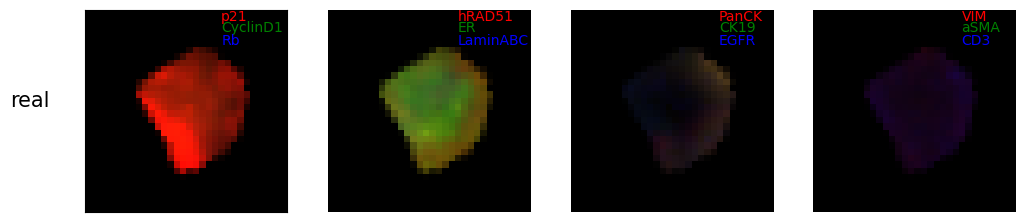

In [235]:
fig, ax = plt.subplots(1,4, figsize=(12,12))
sample_i = 7
ch2stain_ = {i:ch2stain[c] for i,c in enumerate(channels)}

#p21, CyclinD1, RB
ch_idxs = [10,3,8]
pred1 = targets[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
pred2 = targets[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
pred3 = targets[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
ax[0].text(21, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
ax[0].text(21, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
ax[0].text(21, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
ax[0].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_ylabel('real', rotation=0, fontsize=15, labelpad=40)

#HRad51 Histone H2AX laminABC
ch_idxs = [2,6,12]
pred1 = targets[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
pred2 = targets[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
pred3 = targets[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
ax[1].text(20, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
ax[1].text(20, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
ax[1].text(20, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
ax[1].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
ax[1].axis('off')

#Panck ck19 egfr
ch_idxs = 15, 11, 7
pred1 = targets[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
pred2 = targets[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
pred3 = targets[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
ax[2].text(23, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
ax[2].text(23, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
ax[2].text(23, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
ax[2].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
ax[2].axis('off')


## Vim, aSMA, CD3
ch_idxs = [4,5,0]
pred1 = targets[sample_i,:,:, ch_idxs[0]].unsqueeze(2).numpy().astype('uint8')
pred2 = targets[sample_i,:,:, ch_idxs[1]].unsqueeze(2).numpy().astype('uint8')
pred3 = targets[sample_i,:,:, ch_idxs[2]].unsqueeze(2).numpy().astype('uint8')
ax[3].text(23, 1.2, ch2stain_[ch_idxs[0]], dict(size=10), color='red')
ax[3].text(23, 3, ch2stain_[ch_idxs[1]], dict(size=10), color='green')
ax[3].text(23, 5, ch2stain_[ch_idxs[2]], dict(size=10), color='blue')
ax[3].imshow(np.concatenate([pred1, pred2, pred3], axis=2))
ax[3].axis('off')

plt.show()

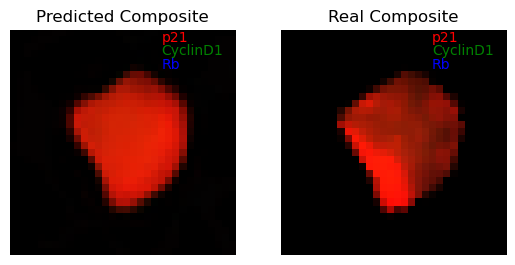

In [224]:
#p21, CyclinD1, RB
show_composite([10, 3, 8], 7)

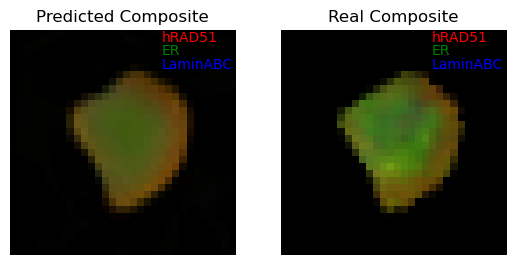

In [220]:
#HRad51 Histone H2AX laminABC
show_composite([2, 6, 12], 7)

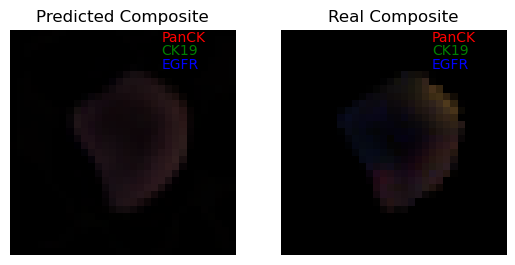

In [222]:
#Panck ck19 egfr
show_composite([15, 11, 7], 7)

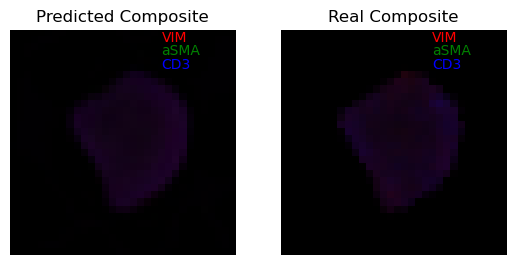

In [223]:
# Vim, aSMA, CD3
show_composite([4, 5, 0], 7)

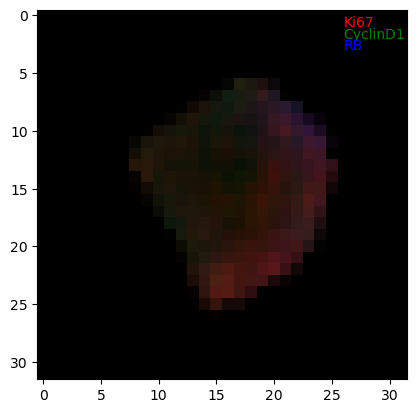

In [155]:
sample_i = 7

pred1 = targets[sample_i,:,:, 13].unsqueeze(2).numpy().astype('uint8')
pred2 = targets[sample_i,:,:, 4].unsqueeze(2).numpy().astype('uint8')
pred3 = targets[sample_i,:,:, 11].unsqueeze(2).numpy().astype('uint8')
pred4 = targets[sample_i,:,:, 15].unsqueeze(2).numpy().astype('uint8')
plt.text(26, 1, 'Ki67', dict(size=10), color='red')
plt.text(26, 2, 'CyclinD1', dict(size=10), color='green')
plt.text(26, 3, 'RB', dict(size=10), color='blue')
plt.imshow(np.concatenate([pred1, pred2, pred3], axis=2))

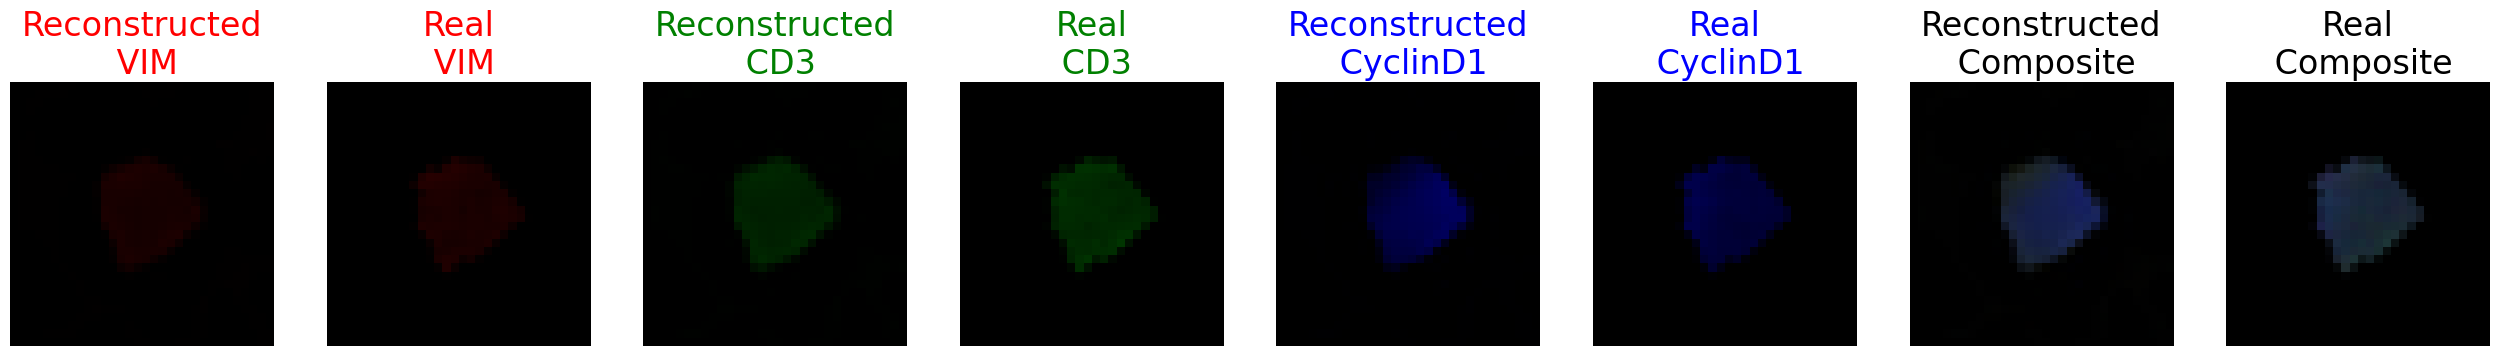

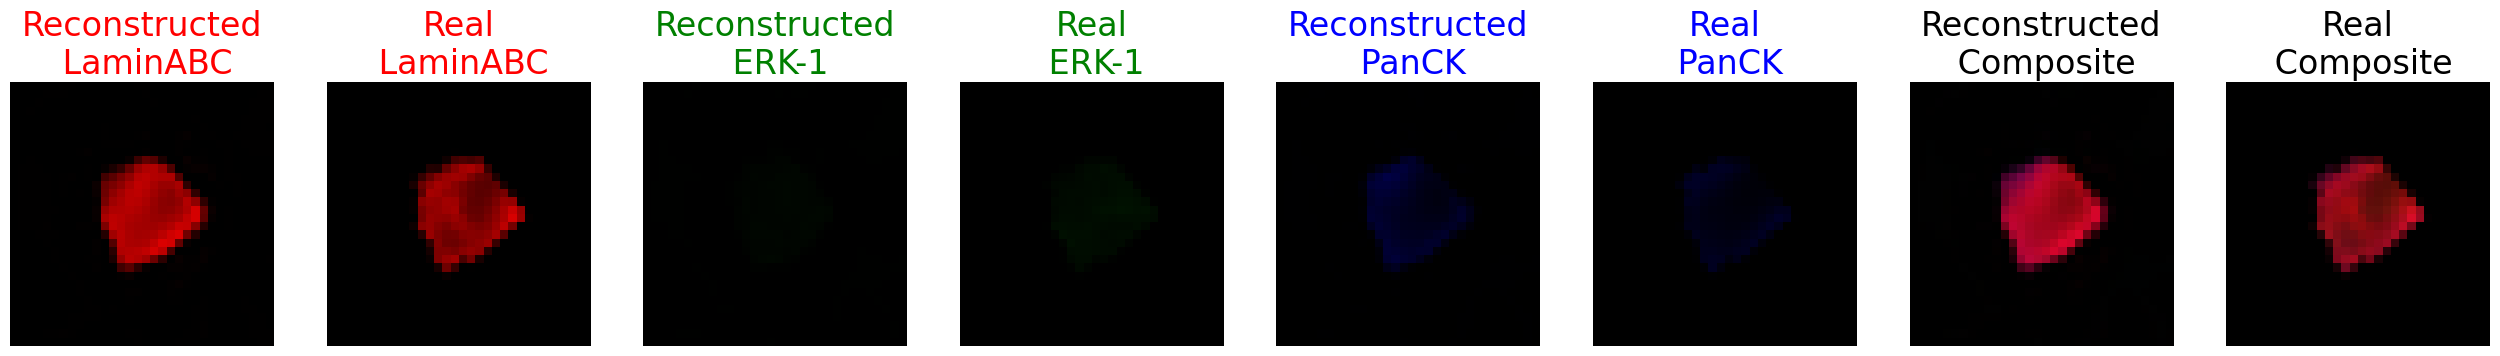

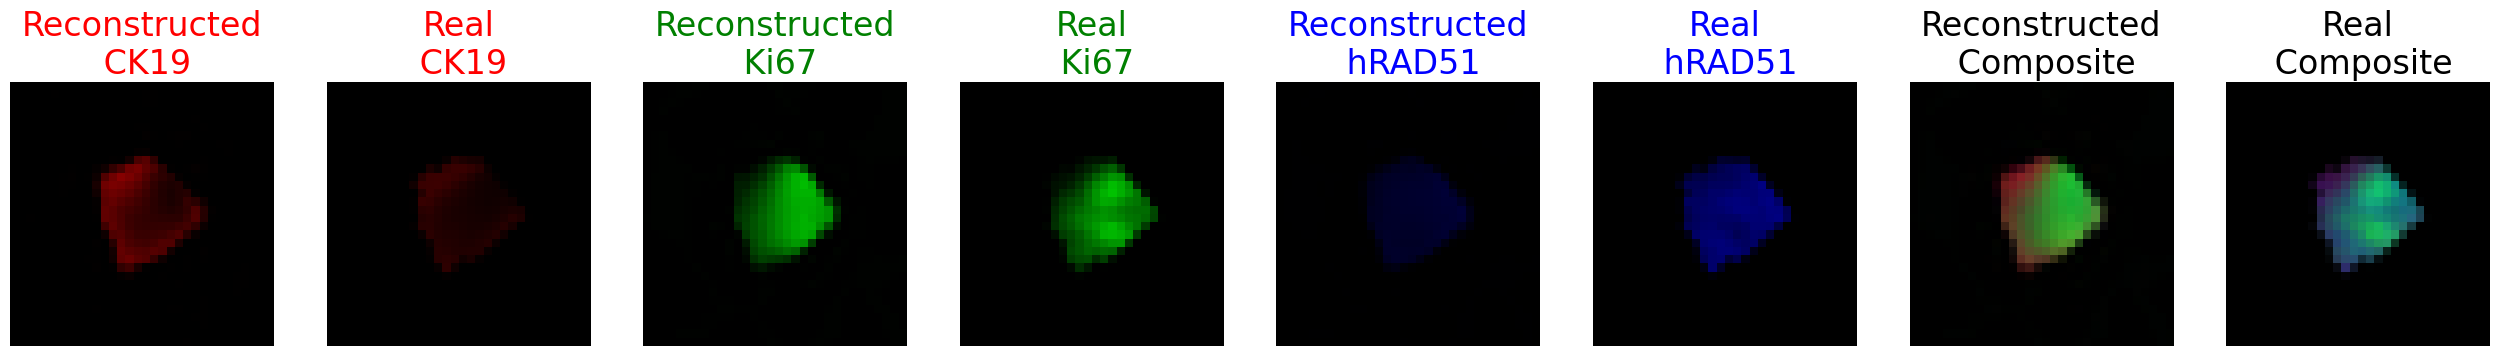

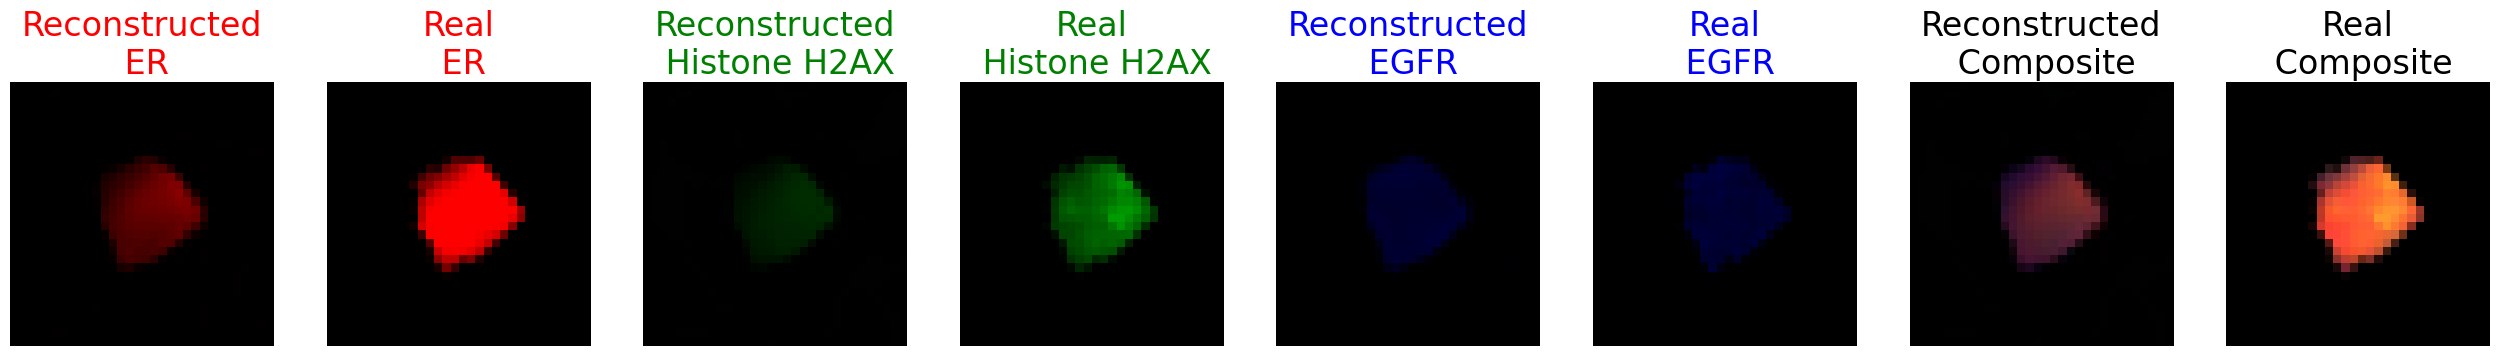

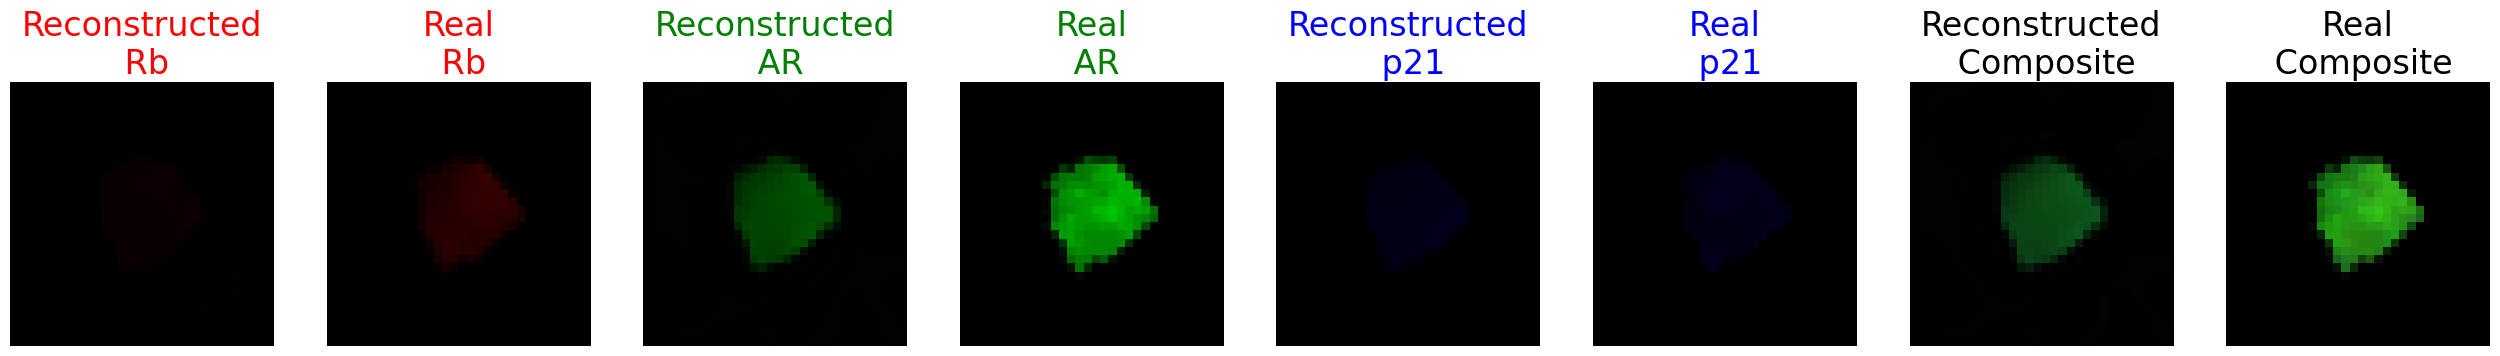

In [40]:
already_used = []
#l = list(range(16))
#shuffle(l)
for i in range(7):
    for ch1, ch2, ch3 in combinations([i for i in l if i not in already_used], 3):
        view_rgb_image(4, ch1, ch2, ch3)
        already_used.extend([ch1, ch2, ch3])
        break